# SPM Figure

Code split into two sections.

First use Richard's code in 'run' mode to calculate the necessary timeseries/datasets for plotting.

To do this with terminal navigate to the directory where the python file is stored using $\textit{cd location/where/pythonfile/is/stored}$ (e.g. for me this $\textit{cd Desktop/for_stuart}$). Then use the command $\textit{python spm_fig_for_stuart.py run}$ to run the code and generate the files for plotting.

The plotting is configured in the following ipython document.

In [1]:
#REQUIRED IMPORTS

# note not all of these are required for the plotting section of the script, will sort and remove unnecessary ones

####################################################################
#IMPORT LIBRARY STATEMENTS 
####################################################################
#Compute libraries
from scipy.ndimage.filters import gaussian_filter1d
from scipy.special import erf, erfinv
from scipy.optimize import root
from scipy.stats import norm, beta
import os
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import zipfile
from fair_scm import *
import datetime
import h5py
import copy
import sys
import deepdish as dd
import numpy as np
from pandas import DataFrame
from statsmodels.api import OLS
import statsmodels.tools.tools

/Users/stuartjenkins/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Plot creation

Code to create the plot of the FAIR SPM figure. 

First need to import the correct files. Then define a number of functions to plot each part of the figure.

Main function which controls the overarll figure plotting is $\textit{plot_spmfig()}$, run this to make the plot and save. 

Final block of code runs the $\textit{plot_spmfig()}$ function, generates the plots, and zips them into a zipfile.

### Main figure creation -- Temperature panels

Functions required to produce the three temperature panels for the main figure. 

The panels for this figure are:

1. $\textit{Main temperature panel}$ -- Temperatures plotted from 1950-2100 showing observed temperatures and projections with uncertainties.

2. $\textit{Higher non-CO2 forcing temperature panel}$ -- Projected temperatures plotted for scenario with higher projected non-CO$_2$ forcing.

3. $\textit{Lower cumulative CO2 emissions temperature panel}$ -- Projected temperatures plotted for scenario with lower projected cumulative CO$_2$ emissions.



#### 1) Main temperature panel

Function to create the main tempearture panel. Past temperature from 1950 through to present day, and trajectory of profiles running through to 2100. Climate response uncertainty for 1.5°C-consistent pathway, marked with observed warming to date, human induced warming uncertainty, and current warming rate. 

In [2]:
def plot_ts_base(ax_main,p_dat,nearterm_ref=False):
    
    obs_keys = p_dat['Obs'].keys()
    
    if nearterm_ref==True:
        p_max = p_dat['Obs']['Temp-max'][:] - np.mean(p_dat['Obs']['Temp-max'][:][np.logical_and(p_dat['Obs']['HadCRUT4']['Years'][:]>2006,p_dat['Obs']['HadCRUT4']['Years'][:]<2016)])
        p_min = p_dat['Obs']['Temp-min'][:] - np.mean(p_dat['Obs']['Temp-min'][:][np.logical_and(p_dat['Obs']['HadCRUT4']['Years'][:]>2006,p_dat['Obs']['HadCRUT4']['Years'][:]<2016)])
        p_mean = p_dat['Obs']['Temp-mean-AWI'][:] - np.mean(p_dat['Obs']['Temp-mean-AWI'][:][np.logical_and(p_dat['Obs']['HadCRUT4']['Years'][:]>2006,p_dat['Obs']['HadCRUT4']['Years'][:]<2016)])
    
    else:
        p_max = p_dat['Obs']['Temp-max'][:]
        p_min = p_dat['Obs']['Temp-min'][:]
        p_mean = p_dat['Obs']['Temp-mean-AWI'][:]
        
    
    #Ascthetic settings
    awi_col = cols['orange']
    gwi_col = cols['vermillion']
    obs_labs = obs_keys
    obs_cols =  ['yellow','green','black','darkred','teal']
        

    plt.fill_between(p_dat['Obs']['HadCRUT4']['Years'],p_max,p_min,color='grey',alpha=0.5,zorder=2)
    plt.plot(p_dat['Obs']['HadCRUT4']['Years'],np.array(p_mean),color=awi_col,linestyle='-',linewidth=2.5,zorder=2)
    
    #Add uncertainty bar on final point for AWI series
    plt.fill_between(p_dat['Obs']['HadCRUT4']['Years'],np.array(p_mean)*(1.2),np.array(p_mean)*(0.8),
    color=awi_col,zorder=5,alpha=0.5,linewidth=0)
    
    
    if nearterm_ref == True:
        plt.axhline(y=1.5-0.87,linewidth=1.5,linestyle='-',color='grey')
        plt.axhline(y=0-0.87,linewidth=1.5,color='grey',linestyle='-',zorder=0)
        plt.text(x=1960, y=0.7-0.87, s='Human-induced\nwarming', fontsize=13,color=awi_col)
    else:
        plt.axhline(y=1.5,linewidth=1.5,linestyle='-',color='grey')
        plt.axhline(y=0,linewidth=1.5,color='grey',linestyle='-',zorder=0)
        plt.text(x=1960, y=0.7, s='Human-induced\nwarming', fontsize=13,color=awi_col)
        
    
    
    warm_end = np.mean(np.array(p_mean)[np.logical_and(np.array(p_dat['Obs']['HadCRUT4']['Years'])>=2017,
    np.array(p_dat['Obs']['HadCRUT4']['Years'])<2018)])
    
    
    
    plt.plot([1950.,2017.5],[warm_end,warm_end],linestyle='--',linewidth=1.5,color=awi_col)
    plt.scatter(2017.5,warm_end,s=30,color=awi_col,zorder=20)
    
    #Add projection for current warming rate 
    proj_years = np.arange(2018,2100)
    warm_rate = 0.021
    plt.plot(proj_years+0.5,warm_end+warm_rate*(proj_years+0.5-2017.5),linestyle='--',color=awi_col,linewidth=2.5,zorder=10)
    
    if nearterm_ref==True:
        plt.plot([2017.5,2017.5],[0-0.87,warm_end],linestyle='--',linewidth=1.5,color=awi_col)
        plt.text(2000,1.81-0.87,'Current warming rate',fontsize=13,color=awi_col)
     
        plt.ylim(0-0.87,2.0-0.87)
        plt.xlim(1950,2100) 
    
        plt.text(1992,0.15-0.87,'Observed\nwarming',fontsize=13,color='grey')
        plt.text(2019,0.93-0.87,'2017',fontsize=8,color=awi_col)
        
    else:
        plt.plot([2017.5,2017.5],[0,warm_end],linestyle='--',linewidth=1.5,color=awi_col)
        plt.text(2000,1.81,'Current warming rate',fontsize=13,color=awi_col)
     
        plt.ylim(0,2.0)
        plt.xlim(1950,2100) 
    
        plt.text(1992,0.15,'Observed\nwarming',fontsize=13,color='grey')
        plt.text(2019,0.93,'2017',fontsize=8,color=awi_col)
    

    return

In [3]:
def plot_lin_co2dec(te,ax_main,nearterm_ref=False):
    
    if nearterm_ref == True:
        plot_uu = te['temp_zero']['RCP8.5'][0][2] - np.mean(te['temp_zero']['RCP8.5'][0][2][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_ul = te['temp_zero']['RCP8.5'][0][4] - np.mean(te['temp_zero']['RCP8.5'][0][4][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_lu = te['temp_zero']['RCP8.5'][0][3] - np.mean(te['temp_zero']['RCP8.5'][0][3][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_ll = te['temp_zero']['RCP8.5'][0][0] - np.mean(te['temp_zero']['RCP8.5'][0][0][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        
    else:
        plot_uu = te['temp_zero']['RCP8.5'][0][2] 
        plot_lu = te['temp_zero']['RCP8.5'][0][3]
        plot_ll = te['temp_zero']['RCP8.5'][0][0] 
        plot_ul = te['temp_zero']['RCP8.5'][0][4] 
        
        

    ax.fill_between(te['years'][te['years'][:]>2017],plot_ll[te['years'][:]>2017]+0.02,plot_uu[te['years'][:]>2017]+0.02,color=cols['bluishgreen'],alpha=0.3,linewidth=0)
    ax.fill_between(te['years'][te['years'][:]>2017],plot_lu[te['years'][:]>2017]+0.02,plot_ul[te['years'][:]>2017]+0.02,color=cols['bluishgreen'],alpha=0.8,linewidth=0)
    
    if nearterm_ref == True:
        ax.text(2040,0.44-0.87,'Climate response \nuncertainty for\n1.5$^{\circ}$C-consistent\npathway',fontsize=13,color=cols['bluishgreen'])

        ax.set_ylabel(r'Warming relative to 2006-2015 ($^{\circ}$C)',fontsize=12)
    else:
        ax.text(2040,0.44,'Climate response \nuncertainty for\n1.5$^{\circ}$C-consistent\npathway',fontsize=13,color=cols['bluishgreen'])

        ax.set_ylabel(r'Warming relative to 1850-1900 ($^{\circ}$C)',fontsize=12)
        
    
    plt.grid()
    ax.set_axisbelow(True)

    
    return

#### 2) Higher non-CO$_2$ forcing temperature panel

Function to format panel b of the final figure, showing impact on temperature of increasing non-CO$_2$ forcing contribution in the future emissions profiles. 

In [4]:
def plot_temppanel(ax,te,lb,nearterm_ref=False):
    
    if nearterm_ref == True:
        plot_uu = te['temp_zero']['RCP8.5'][0][2] - np.mean(te['temp_zero']['RCP8.5'][0][2][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_ul = te['temp_zero']['RCP8.5'][0][4] - np.mean(te['temp_zero']['RCP8.5'][0][4][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_lu = te['temp_zero']['RCP8.5'][0][3] - np.mean(te['temp_zero']['RCP8.5'][0][3][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_ll = te['temp_zero']['RCP8.5'][0][0] - np.mean(te['temp_zero']['RCP8.5'][0][0][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        
        plot_uu_a = lb['temp_zero']['RCP8.5'][0][2] - np.mean(lb['temp_zero']['RCP8.5'][0][2][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_ul_a = lb['temp_zero']['RCP8.5'][0][4] - np.mean(lb['temp_zero']['RCP8.5'][0][4][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_lu_a = lb['temp_zero']['RCP8.5'][0][3] - np.mean(lb['temp_zero']['RCP8.5'][0][3][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_ll_a = lb['temp_zero']['RCP8.5'][0][0] - np.mean(lb['temp_zero']['RCP8.5'][0][0][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        
    else:
        plot_uu = te['temp_zero']['RCP8.5'][0][2] 
        plot_lu = te['temp_zero']['RCP8.5'][0][3]
        plot_ll = te['temp_zero']['RCP8.5'][0][0] 
        plot_ul = te['temp_zero']['RCP8.5'][0][4]
        
        plot_uu_a = lb['temp_zero']['RCP8.5'][0][2] 
        plot_lu_a = lb['temp_zero']['RCP8.5'][0][3]
        plot_ll_a = lb['temp_zero']['RCP8.5'][0][0]
        plot_ul_a = lb['temp_zero']['RCP8.5'][0][4]
    
    
    if nearterm_ref == True:
        ax.axhline(y=1.5-0.87,linewidth=1.5,linestyle='-',color='grey')
    else:
        ax.axhline(y=1.5,linewidth=1.5,linestyle='-',color='grey')
    
    ax.fill_between(lb['years'][lb['years'][:]>2017],plot_lu_a[lb['years'][:]>2017]+0.02,plot_ul_a[lb['years'][:]>2017]+0.02,
    color=cols['vermillion'],linewidth=0,alpha=0.8)
    ax.fill_between(lb['years'][lb['years'][:]>2017],plot_ll_a[lb['years'][:]>2017]+0.02,plot_uu_a[lb['years'][:]>2017]+0.02,
    color=cols['vermillion'],linewidth=0,alpha=0.3)
    
    ax.plot(te['years'][te['years'][:]>2017],plot_ll[te['years'][:]>2017]+0.02,color=cols['bluishgreen'],linestyle='--')
    ax.plot(te['years'][te['years'][:]>2017],plot_lu[te['years'][:]>2017]+0.02,color=cols['bluishgreen'],linestyle='--')
    ax.plot(te['years'][te['years'][:]>2017],plot_ul[te['years'][:]>2017]+0.02,color=cols['bluishgreen'],linestyle='--')
    ax.plot(te['years'][te['years'][:]>2017],plot_uu[te['years'][:]>2017]+0.02,color=cols['bluishgreen'],linestyle='--')

    
    #ax.text(2025,1.9,'Lower future cumulative\nCO$_{2}$ emissions',color=cols['vermillion'],fontsize=10)
    ax.set_xlim(2020,2100)
    if nearterm_ref == True:
        ax.set_ylim(0.8-0.87,2.2-0.87)
        ax.set_ylabel('Warming relative to\n2006-2015 ($^{\circ}$C)',fontsize=8)
    else:
        ax.set_ylim(0.8,2.2)
        ax.set_ylabel('Warming relative to\n1850-1900 ($^{\circ}$C)',fontsize=8)
    ax.grid()
    
    
    
    return

#### 3) Lower cumulative CO$_2$ emissions temperature panel

Function to format panel c of the final figure, showing impact on temperature of lower future cumulative CO$_2$ emissions.

In [5]:
def plot_temppanel_alt(ax,te,lb,nearterm_ref=False):
    
    if nearterm_ref == True:
        plot_uu = te['temp_zero']['RCP8.5'][0][2] - np.mean(te['temp_zero']['RCP8.5'][0][2][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_ul = te['temp_zero']['RCP8.5'][0][4] - np.mean(te['temp_zero']['RCP8.5'][0][4][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_lu = te['temp_zero']['RCP8.5'][0][3] - np.mean(te['temp_zero']['RCP8.5'][0][3][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_ll = te['temp_zero']['RCP8.5'][0][0] - np.mean(te['temp_zero']['RCP8.5'][0][0][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        
        plot_uu_a = te['temp_zero']['RCP8.5'][1][2] - np.mean(te['temp_zero']['RCP8.5'][1][2][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_ul_a = te['temp_zero']['RCP8.5'][1][4] - np.mean(te['temp_zero']['RCP8.5'][1][4][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_lu_a = te['temp_zero']['RCP8.5'][1][3] - np.mean(te['temp_zero']['RCP8.5'][1][3][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_ll_a = te['temp_zero']['RCP8.5'][1][0] - np.mean(te['temp_zero']['RCP8.5'][1][0][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        
    else:
        plot_uu = te['temp_zero']['RCP8.5'][0][2] 
        plot_lu = te['temp_zero']['RCP8.5'][0][3]
        plot_ll = te['temp_zero']['RCP8.5'][0][0] 
        plot_ul = te['temp_zero']['RCP8.5'][0][4]
        
        plot_uu_a = te['temp_zero']['RCP8.5'][1][2] 
        plot_lu_a = te['temp_zero']['RCP8.5'][1][3]
        plot_ll_a = te['temp_zero']['RCP8.5'][1][0]
        plot_ul_a = te['temp_zero']['RCP8.5'][1][4]
    
    
    
    if nearterm_ref == True:
        ax.axhline(y=1.5-0.87,linewidth=1.5,linestyle='-',color='grey')
    else:
        ax.axhline(y=1.5,linewidth=1.5,linestyle='-',color='grey')
    
    ax.fill_between(te['years'][te['years'][:]>2017],plot_lu_a[te['years'][:]>2017]+0.02,plot_ul_a[te['years'][:]>2017]+0.02,
    color=cols['blue'],linewidth=0,alpha=0.8)
    ax.fill_between(lb['years'][te['years'][:]>2017],plot_ll_a[te['years'][:]>2017]+0.02,plot_uu_a[te['years'][:]>2017]+0.02,
    color=cols['blue'],linewidth=0,alpha=0.3)
    
    ax.plot(te['years'][te['years'][:]>2017],plot_ll[te['years'][:]>2017]+0.02,color=cols['bluishgreen'],linestyle='--')
    ax.plot(te['years'][te['years'][:]>2017],plot_lu[te['years'][:]>2017]+0.02,color=cols['bluishgreen'],linestyle='--')
    ax.plot(te['years'][te['years'][:]>2017],plot_ul[te['years'][:]>2017]+0.02,color=cols['bluishgreen'],linestyle='--')
    ax.plot(te['years'][te['years'][:]>2017],plot_uu[te['years'][:]>2017]+0.02,color=cols['bluishgreen'],linestyle='--')
    
    #ax.text(2025,1.9,'Higher future non-CO$_{2}$\nradiative forcing',color=cols['blue'],fontsize=10)
    
    ax.set_xlim(2020,2100)
    if nearterm_ref == True:
        ax.set_ylim(0.8-0.87,2.2-0.87)
        ax.set_ylabel('Warming relative to\n2006-2015 ($^{\circ}$C)',fontsize=8)
    else:
        ax.set_ylim(0.8,2.2)
        ax.set_ylabel('Warming relative to\n1850-1900 ($^{\circ}$C)',fontsize=8)
    ax.grid()
    
    return

### Main figure creation 2 -- driver panels

Functions required to produce the panels for figure showing $\textbf{drivers}$ of the scenarios plotted on main temperature figure.

The panels for this figure are:

1. $\textit{'Annual CO2 emissions panel'}$ -- Historical emissions plotted from 1950 with uncertainties, idealised CO2 emissions scenarios from 2020 decreasing linearly to zero by 2057 (2040).

2. $\textit{'Cumulative CO2 emissions panel'}$ -- Cumulative CO2 emissions plotted between 1950 and 2100, showing the two scenarios plotted as annual emissions in panel 1. Historical CO2 emissions have attached uncertainty (shaded), and two scenarios show projected cumulative CO2 emissions.

3. $\textit{'Non-CO2 radiative forcing panel'}$ -- Non-CO2 radiative forcing profiles, plotted betwee n1950 and 2100. Historical profile in black with uncertainty arked at present day. Two future scenarios plotted, decreasing non-CO2 forcing after peak ($\approx$ 2030), or constant radiative forcing contribution from non-CO2 forcing after peak.




#### 1) Annual CO2 emissions panel

Function to plot the annual CO2 emssions used to drive the temperature figure plot.

In [6]:
def plot_emissionspanel_an(ax1,te,lb,gcp_data,gcp_ems):
    
    #Plot the emissions pathway
    ax1.axhline(y=0,linewidth=1.5,color='black',linestyle='-',zorder=0)
    
    cum_high = 44./12*(np.cumsum(te['llems_zero']['RCP8.5'][0][1]))
    cum_high = cum_high[te['years'][:]>=2017] - cum_high[te['years'][:]==1870]
    cum_low = 44./12*(np.cumsum(lb['llems_zero']['RCP8.5'][0][1]))
    cum_low = cum_low[lb['years'][:]>=2017] - cum_low[lb['years'][:]==1870]

    ax1.plot(te['years'][te['years'][:]>=2017],44./12*te['llems_zero']['RCP8.5'][0][1][te['years'][:]>=2017],color=cols['bluishgreen'],linewidth=2)
    ax1.plot(lb['years'][lb['years'][:]>=2017],44./12*lb['llems_zero']['RCP8.5'][0][1][lb['years'][:]>=2017],color=cols['vermillion'],linewidth=2)
    ax1.fill_between(lb['years'][lb['years'][:]>=2017],44./12*lb['llems_zero']['RCP8.5'][0][1][lb['years'][:]>=2017],color=cols['vermillion'],linewidth=0,alpha=0.3)
    ax1.fill_between(te['years'][te['years'][:]>=2017],44./12*te['llems_zero']['RCP8.5'][0][1][te['years'][:]>=2017],
    44./12*lb['llems_zero']['RCP8.5'][0][1][lb['years'][:]>=2017],color=cols['bluishgreen'],linewidth=0,alpha=0.3)
    

    ax1.plot(gcp_data['Year'][gcp_data['Year']>=1850],44./12*gcp_ems[gcp_data['Year']>=1850],color='black',linewidth=2)
    ax1.fill_between(gcp_data['Year'][gcp_data['Year']>=1850],44./12*gcp_ems[gcp_data['Year']>=1850],color=cols['vermillion'],linewidth=0,alpha=0.3)
    ax1.fill_between(gcp_data['Year'][gcp_data['Year']>=1850],44./12*1.08*gcp_ems[gcp_data['Year']>=1850],44./12*0.92*gcp_ems[gcp_data['Year']>=1850],color='grey',linewidth=0,alpha=0.3)
    
    
    obs_line = mlines.Line2D([],[],linestyle='-',color='black',linewidth=2)
    lb_line = mlines.Line2D([],[],linestyle='--',color=cols['bluishgreen'],linewidth=2)
    te_line = mlines.Line2D([],[],linestyle='-',color=cols['bluishgreen'],linewidth=2)
    
    ax1.set_xlim(1950,2100)
    #ax1.set_ylim(-2000,1500)
    ax1.set_ylim(0,55)
    ax1.grid()
    ax1.set_ylabel('GtCO$_{2}$/yr',fontsize=12)
    
    ax1.text(0.95,0.9,'Annual CO$_{2}$ emissions',fontsize=12,transform=ax1.transAxes,ha='right')
    

    
    return

#### 2) Cumulative CO2 emissions panel

Function to plot the cumulative CO2 emssions used to drive the temperature figure plot.

In [7]:
def plot_cumemissionspanel(ax1,te,lb,gcp_data,gcp_ems):
    
    #Plot the emissions pathway
    ax1.axhline(y=0,linewidth=1.5,color='black',linestyle='-',zorder=0)
    
    cum_high = 44./12*(np.cumsum(te['llems_zero']['RCP8.5'][0][1]))
    cum_high = cum_high[te['years'][:]>=2017] - cum_high[te['years'][:]==1870]
    cum_low = 44./12*(np.cumsum(lb['llems_zero']['RCP8.5'][0][1]))
    cum_low = cum_low[lb['years'][:]>=2017] - cum_low[lb['years'][:]==1870]

    ax1.plot(te['years'][te['years'][:]>=2017],cum_high,color=cols['bluishgreen'],linewidth=2)
    ax1.plot(lb['years'][lb['years'][:]>=2017],cum_low,color=cols['vermillion'],linewidth=2)
      
    gcp_ems[0] = 0
    cum_gcp = 44./12*np.cumsum(gcp_ems ) 
    cum_gcp = cum_gcp[gcp_data['Year']>=1850] - cum_gcp[gcp_data['Year']==1870]

    ax1.plot(gcp_data['Year'][gcp_data['Year']>=1850],cum_gcp,color='black',linewidth=2)
    #ax1.fill_between(gcp_data['Year'][gcp_data['Year']>=1850],1.11*cum_gcp,0.88*cum_gcp,44./12*0.92*gcp_ems[gcp_data['Year']>=1850],color='grey',linewidth=0,alpha=0.3)
    ax1.fill_between(gcp_data['Year'][gcp_data['Year']>=1850],1.11*cum_gcp,0.88*cum_gcp,color='grey',linewidth=0,alpha=0.3)

    obs_line = mlines.Line2D([],[],linestyle='-',color='black',linewidth=2)
    lb_line = mlines.Line2D([],[],linestyle='--',color=cols['bluishgreen'],linewidth=2)
    te_line = mlines.Line2D([],[],linestyle='-',color=cols['bluishgreen'],linewidth=2)
    
    ax1.set_xlim(1950,2100)
    #ax1.set_ylim(-2000,1500)
    ax1.set_ylim(0,3500)
    ax1.grid()
    ax1.set_ylabel('GtCO$_{2}$',fontsize=12)
    
    ax1.text(0.95,0.9,'Cumulative CO$_{2}$ emissions',fontsize=12,transform=ax1.transAxes,ha='right')
    
    

    
    return

#### 3) Non-CO2 radiative forcing panel

Function to plot the non-CO2 radiative forcing contribution used to drive the temperature figure plot.

In [8]:
def plot_forcingpanel(ax2,te,lb):
    
    ax2.axhline(y=0,linewidth=1.5,color='black',linestyle='-',zorder=0)

    ax2.plot(te['years'],te['slcp_zero']['RCP8.5'][0][1],color=cols['bluishgreen'],linewidth=2)
    ax2.plot(te['years'],te['slcp_zero']['RCP8.5'][1][1],color=cols['blue'],linewidth=2)
    ax2.plot(te['years'][te['years'][:]<=2011],te['slcp_zero']['RCP8.5'][1][1][te['years'][:]<=2011],color='black',linewidth=2)
    
    ax2.set_xlim(1950,2100)
    ax2.set_ylim(-0.2,1.3)
    ax2.grid()
    ax2.set_ylabel('Wm$^{-2}$',fontsize=12)
    
    ax2.text(0.95,0.9,'Non-CO$_{2}$ radiative forcing',fontsize=12,transform=ax2.transAxes,ha='right')
    
    #Scale AR5 uncertainty down to likely range 
    mu_nco2 = 0.5*(1.13 + 3.33) - 1.68
    sig_nco2 = (1.13 - 1.68 - mu_nco2)/(erfinv((0.05)*2 - 1)*np.sqrt(2.0))
    nco2_range = sig_nco2 * np.sqrt(2.0) * erfinv(2*(np.array([0.17,0.83])) -1.0) + mu_nco2
    ax2.errorbar(2011,mu_nco2,mu_nco2-nco2_range[0],fmt='none',elinewidth=1,ecolor='black',capsize=3)
    
    
    return

### Overall figure creation and pdf save

Functions to create the overall figure (i.e. controls the run of each function to create parts of the figure.)

In [9]:
# Define function to load in the saved plot data.

def load_plot_data(filename):
    #Load the latest available data for plotting
    f = h5py.File(filename, 'r')
    return f

In [10]:
#Define and run function to load the colours for plotting.
def load_colpal():
    
    #Colourblind friendly list
    rgb_list = np.array([[0,0,0],[230,159,0],[86,180,233],[0,158,115],
                [240,228,66],[0,114,178],[213,94,0],[204,121,167]]) / 255.
                
    rgb_names = ['black','orange','skyblue','bluishgreen','yellow',
                'blue','vermillion','reddishpurple']
                
    rgbs = {rgb_names[x]:tuple(rgb_list[x]) for x in range(0,len(rgb_list))}
    
    return rgbs
  

cols = load_colpal()

In [11]:
def plot_spmfig(nearterm_ref=False):
    
    plot_files = []
    
    gcp_data= np.genfromtxt('./Data/gcp_data_2017_prelim.csv',delimiter=',',
    dtype=np.dtype({'names':['Year','FFI','LUC'],'formats':3*[np.float]}))
    gcp_ems = gcp_data['FFI'] + gcp_data['LUC']
    #Load the scenarios non-CO2 forcing 
    scen_data = np.genfromtxt('./Data/F_oth.txt',skip_header=1)
    #Load the scenarios CO2 emissions 
    scen_data_co2 = np.genfromtxt('./Data/E_co2.txt',skip_header=1)
    
    
    now = datetime.datetime.now()
    data_files = ['./spmfig/output/'+f for f in os.listdir('./spmfig/output/') if f[-3:]=='.h5']
    if len(data_files)==0:
        print 'No available plotting data'
        return
        
    #Convert datatags into datetime objects to find the youngest one
    dates = [datetime.datetime.strptime('_'.join(f.split('_')[-2:])[:-3],'%d%m%Y_%H:%M:%S') for f in data_files]
    plot_file = './spmfig/output/fig1.1_plotdata_'+max(dates).strftime('%d%m%Y_%H:%M:%S')+'.h5'
    
    plot_files.append(plot_file)
    
    p_dat = load_plot_data(plot_file)
    

    #Load the future scenario objects 
    now = datetime.datetime.now()
    data_files = ['./spmfig/output/'+f for f in os.listdir('./spmfig/output/') if (f[-3:]=='.h5' and f.split('_')[2]=='te')]
    if len(data_files)==0:
        print 'No available plotting data'
        return
        
    #Convert datatags into datetime objects to find the youngest one
    dates = [datetime.datetime.strptime('_'.join(f.split('_')[-2:])[:-3],'%d%m%Y_%H:%M:%S') for f in data_files]
    te_plot_file = './spmfig/output/spmfig_plotdata_te_'+max(dates).strftime('%d%m%Y_%H:%M:%S')+'.h5'
    
    data_files = ['./spmfig/output/'+f for f in os.listdir('./spmfig/output/') if (f[-3:]=='.h5' and f.split('_')[2]=='lb')]
    if len(data_files)==0:
        print 'No available plotting data'
        return
        
    #Convert datatags into datetime objects to find the youngest one
    dates = [datetime.datetime.strptime('_'.join(f.split('_')[-2:])[:-3],'%d%m%Y_%H:%M:%S') for f in data_files]
    lb_plot_file = './spmfig/output/spmfig_plotdata_lb_'+max(dates).strftime('%d%m%Y_%H:%M:%S')+'.h5'
    
    te = load_plot_data(te_plot_file)
    lb = load_plot_data(lb_plot_file)
    
    plot_files.append(te_plot_file)
    plot_files.append(lb_plot_file)
    
    main_xstart = 0.12
    main_xwidth = 0.77
    main_ystart = 0.61
    main_ywidth = 0.34


    fig = plt.figure(figsize=(7,7))
    ax = fig.add_axes([main_xstart,main_ystart,main_xwidth,main_ywidth])
    plot_ts_base(ax,p_dat,nearterm_ref=nearterm_ref)
    plot_lin_co2dec(te,ax,nearterm_ref=nearterm_ref)
    
    sub_xstart = 0.5*(2*main_xstart + main_xwidth) - 0.025
    sub_xwidth = main_xstart + main_xwidth - sub_xstart
    
    
    #Preserve the aspect ratio of the temperature data 
    sub_ywidth = (main_ywidth/main_xwidth) / (2.0/(2100-1950.)) * (sub_xwidth/(2100-2020.)) * (2.2-0.8)
    
    ax3= fig.add_axes([sub_xstart, 0.04, sub_xwidth, sub_ywidth])
    ax4= fig.add_axes([sub_xstart, 0.32, sub_xwidth, sub_ywidth])
    
    plot_temppanel(ax3,te,lb,nearterm_ref=nearterm_ref)
    plot_temppanel_alt(ax4,te,lb,nearterm_ref=nearterm_ref)
    

    plt.figtext(0.08,0.45,'Higher future non-CO$_{2}$\nradiative forcing',color=cols['blue'],fontsize=12)
    plt.figtext(0.08,0.15,'Lower future cumulative\nCO$_{2}$ emissions',color=cols['vermillion'],fontsize=12)

    
    fig_filename = './spmfig/output/plots/spmfig1_'+now.strftime('%d%m%Y_%H:%M:%S')+'.pdf'
    fig.savefig(fig_filename,dpi=300)
    fig.savefig(fig_filename[:-3]+'svg',dpi=300)
    
    
    fig_d = plt.figure(figsize=(6,6))
    ax1= fig_d.add_axes([0.12, 0.7, 0.77, 0.25])    
    ax2= fig_d.add_axes([0.12, 0.4, 0.77, 0.25])
    ax_e = fig_d.add_axes([0.12, 0.1, 0.77, 0.25])
    
    plot_cumemissionspanel(ax2,te,lb,gcp_data,gcp_ems)
    plot_emissionspanel_an(ax1,te,lb,gcp_data,gcp_ems)
    plot_forcingpanel(ax_e,te,lb)
    fig_filename_d = './spmfig/output/plots/spmfig1_drivers_'+now.strftime('%d%m%Y_%H:%M:%S')+'.pdf'
    fig_d.savefig(fig_filename_d,dpi=300)
    fig_d.savefig(fig_filename_d[:-3]+'svg',dpi=300)

    return plot_files, fig_filename

In [12]:
plot_files, fig_file = plot_spmfig(nearterm_ref=False)
zf = zipfile.ZipFile('./spmfig/output/zips/'+fig_file.split('/')[-1][:-4]+'.zip', mode='w')
zf.write(fig_file,compress_type=zipfile.ZIP_DEFLATED)
for f in plot_files:
    zf.write(f,compress_type=zipfile.ZIP_DEFLATED)
zf.write('./Data/gcp_data_2017_prelim.csv',compress_type=zipfile.ZIP_DEFLATED)
zf.write('./Data/F_oth.txt',compress_type=zipfile.ZIP_DEFLATED)
zf.write(sys.argv[0],compress_type=zipfile.ZIP_DEFLATED)
zf.close()

# Figure redesign...

Build a figure design which looks somewhat like the SPM figure layout.

First try a simple 4 panel layout with temperature as the headline and contributions to it on left in small panels. 

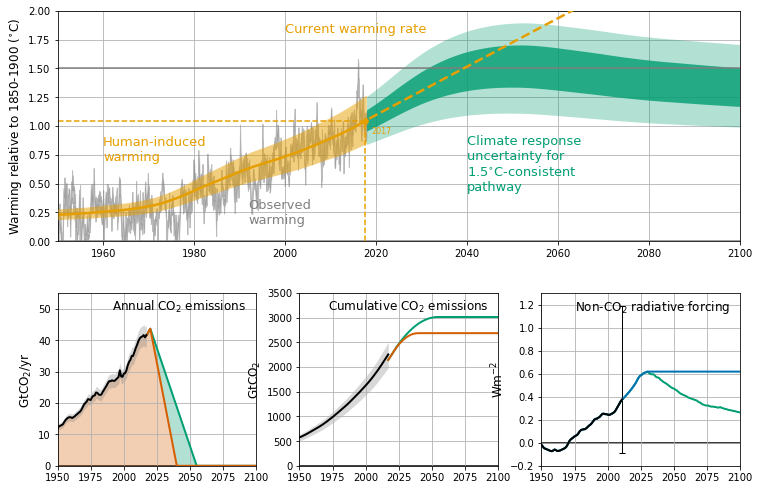

In [30]:
plt.close()

def SPM_fig_simple(ax_main, ax_left, ax_middle, ax_right, nearterm_ref=False):
    
    plot_files = []
    
    gcp_data= np.genfromtxt('./Data/gcp_data_2017_prelim.csv',delimiter=',',
    dtype=np.dtype({'names':['Year','FFI','LUC'],'formats':3*[np.float]}))
    gcp_ems = gcp_data['FFI'] + gcp_data['LUC']
    #Load the scenarios non-CO2 forcing 
    scen_data = np.genfromtxt('./Data/F_oth.txt',skip_header=1)
    #Load the scenarios CO2 emissions 
    scen_data_co2 = np.genfromtxt('./Data/E_co2.txt',skip_header=1)
    
    
    now = datetime.datetime.now()
    data_files = ['./spmfig/output/'+f for f in os.listdir('./spmfig/output/') if f[-3:]=='.h5']
    if len(data_files)==0:
        print 'No available plotting data'
        return
        
    #Convert datatags into datetime objects to find the youngest one
    dates = [datetime.datetime.strptime('_'.join(f.split('_')[-2:])[:-3],'%d%m%Y_%H:%M:%S') for f in data_files]
    plot_file = './spmfig/output/fig1.1_plotdata_'+max(dates).strftime('%d%m%Y_%H:%M:%S')+'.h5'
    
    plot_files.append(plot_file)
    
    p_dat = load_plot_data(plot_file)
    

    #Load the future scenario objects 
    now = datetime.datetime.now()
    data_files = ['./spmfig/output/'+f for f in os.listdir('./spmfig/output/') if (f[-3:]=='.h5' and f.split('_')[2]=='te')]
    if len(data_files)==0:
        print 'No available plotting data'
        return
        
    #Convert datatags into datetime objects to find the youngest one
    dates = [datetime.datetime.strptime('_'.join(f.split('_')[-2:])[:-3],'%d%m%Y_%H:%M:%S') for f in data_files]
    te_plot_file = './spmfig/output/spmfig_plotdata_te_'+max(dates).strftime('%d%m%Y_%H:%M:%S')+'.h5'
    
    data_files = ['./spmfig/output/'+f for f in os.listdir('./spmfig/output/') if (f[-3:]=='.h5' and f.split('_')[2]=='lb')]
    if len(data_files)==0:
        print 'No available plotting data'
        return
        
    #Convert datatags into datetime objects to find the youngest one
    dates = [datetime.datetime.strptime('_'.join(f.split('_')[-2:])[:-3],'%d%m%Y_%H:%M:%S') for f in data_files]
    lb_plot_file = './spmfig/output/spmfig_plotdata_lb_'+max(dates).strftime('%d%m%Y_%H:%M:%S')+'.h5'
    
    te = load_plot_data(te_plot_file)
    lb = load_plot_data(lb_plot_file)
    
    plot_files.append(te_plot_file)
    plot_files.append(lb_plot_file)
    
    #plot temperature figure
    plot_ts_base(ax_main,p_dat,nearterm_ref=nearterm_ref)
    plot_lin_co2dec(te,ax_main,nearterm_ref=nearterm_ref)
    
    #plot 3 subplots
    plot_cumemissionspanel(ax_middle,te,lb,gcp_data,gcp_ems)
    plot_emissionspanel_an(ax_left,te,lb,gcp_data,gcp_ems)
    plot_forcingpanel(ax_right,te,lb)
    
    
    return ax_main, ax_left, ax_middle, ax_right, plot_files


#################################################################################################
# define a figure shape and run main temperature figure creator on it to show it works

main_xstart = 0.12
main_xwidth = 0.79
main_ystart = 0.50
main_ywidth = 0.40

left_xstart = 0.12
left_xwidth = 0.23
left_ystart = 0.11
left_ywidth = 0.30

mid_xstart = 0.40
mid_xwidth = 0.23
mid_ystart = 0.11
mid_ywidth = 0.30

right_xstart = 0.68
right_xwidth = 0.23
right_ystart = 0.11
right_ywidth = 0.30

fig = plt.figure(figsize=(12,8))
ax_left = fig.add_axes([left_xstart,left_ystart,left_xwidth,left_ywidth])
ax_middle = fig.add_axes([mid_xstart,mid_ystart,mid_xwidth,mid_ywidth])
ax_right = fig.add_axes([right_xstart,right_ystart,right_xwidth,right_ywidth])
ax_main = fig.add_axes([main_xstart,main_ystart,main_xwidth,main_ywidth])

ax_main, ax_left, ax_middle, ax_right, plot_files_1 = SPM_fig_simple(ax_main, ax_left, ax_middle, ax_right, nearterm_ref=False)
plt.show()

#fig.savefig('testforshape')